In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Carregar dados limpos
df = pd.read_csv(r'C:\Users\João Pedro\Documents\UFG\AMS\AS2\data\train_cleaned.csv')

def feature_engineering_trees(df):
    df_feat = df.copy()
    
    if 'Cabin' in df_feat.columns:
        df_feat[['Deck', 'Num', 'Side']] = df_feat['Cabin'].str.split('/', expand=True)
        df_feat['Num'] = pd.to_numeric(df_feat['Num'], errors='coerce').fillna(0)
    
    # GASTOS (Total e Log)
    cols_gastos = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    df_feat['TotalSpend'] = df_feat[cols_gastos].sum(axis=1)
    
    for col in cols_gastos + ['TotalSpend', 'Num']:
        if col in df_feat.columns:
            df_feat[col] = np.log1p(df_feat[col])
            
    # FORMATAR BOOLEANOS (True/False -> 1/0)
    bool_cols = ['CryoSleep', 'VIP']
    for col in bool_cols:
        if col in df_feat.columns:
            df_feat[col] = df_feat[col].astype(int)

    # Removemos colunas de alta cardinalidade que não ajudam árvores
    # Group e Surname podem ser removidos pois já temos GroupSize e FamilySize
    cols_drop = ['PassengerId', 'Name', 'Cabin', 'Group', 'Surname']
    df_feat = df_feat.drop(columns=[c for c in cols_drop if c in df_feat.columns])
    
    return df_feat

# Aplicar engenharia
df_processed = feature_engineering_trees(df)

# Separar X e y
X = df_processed.drop('Transported', axis=1)
y = df_processed['Transported'].astype(int)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("Features disponíveis:", list(X.columns))

Features disponíveis: ['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'FamilySize', 'GroupSize', 'Deck', 'Num', 'Side', 'TotalSpend']


In [ ]:
from catboost import CatBoostClassifier, Pool

# 1. Identificar colunas categóricas (Texto)
cat_features = ['HomePlanet', 'Destination', 'Deck', 'Side']

X_train[cat_features] = X_train[cat_features].astype(str)
X_val[cat_features] = X_val[cat_features].astype(str)

# Criar Pools (Otimiza o carregamento de dados)
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_features)
val_pool = Pool(data=X_val, label=y_val, cat_features=cat_features)

# Definir e Treinar Modelo
model_cat = CatBoostClassifier(
    iterations=1000,        # Número máximo de árvores
    learning_rate=0.03,     
    depth=6,                # Profundidade da árvore
    eval_metric='Accuracy', # Métrica para monitorar
    verbose=100,            # Imprimir a cada 100 iterações
    early_stopping_rounds=50 # Para se parar de melhorar
)

print("\n--- Treinando CatBoost ---")
model_cat.fit(train_pool, eval_set=val_pool)

print(f"Melhor Acurácia Validação: {model_cat.get_best_score()['validation']['Accuracy']:.4f}")

# Salvar
model_cat.save_model('modelo_catboost.cbm')


--- Treinando CatBoost ---
0:	learn: 0.7621513	test: 0.7538815	best: 0.7538815 (0)	total: 169ms	remaining: 2m 48s
100:	learn: 0.8126258	test: 0.7970098	best: 0.7970098 (100)	total: 3.88s	remaining: 34.6s
200:	learn: 0.8283003	test: 0.7987349	best: 0.8004600 (185)	total: 7.71s	remaining: 30.7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8004600345
bestIteration = 185

Shrink model to first 186 iterations.
Melhor Acurácia Validação: 0.8005


In [ ]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool

# Função de preparação de dados com engenharia avançada
def preparar_dados_catboost_completo(df, eh_treino=True):
    df_proc = df.copy()
    
    # Tratamento de nulos
    num_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in num_cols:
        if col in df_proc.columns:
            df_proc[col] = df_proc[col].fillna(0)
            
    # Preencher categóricos com "Unknown"
    cat_cols_raw = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin']
    for col in cat_cols_raw:
        if col in df_proc.columns:
            df_proc[col] = df_proc[col].fillna('Unknown')


    if 'Cabin' in df_proc.columns:
        cabine_split = df_proc['Cabin'].str.split('/', expand=True)
        if len(cabine_split.columns) == 3:
            df_proc['Deck'] = cabine_split[0].fillna('Unknown')
            df_proc['Num'] = pd.to_numeric(cabine_split[1], errors='coerce').fillna(0)
            df_proc['Side'] = cabine_split[2].fillna('Unknown')
        else:
            df_proc['Deck'] = 'Unknown'
            df_proc['Num'] = 0
            df_proc['Side'] = 'Unknown'

    
    # LUXO vs BÁSICO
    df_proc['LuxurySpend'] = df_proc['RoomService'] + df_proc['Spa'] + df_proc['VRDeck']
    df_proc['BasicSpend'] = df_proc['FoodCourt'] + df_proc['ShoppingMall']
    
    # CONTAGEM DE SERVIÇOS
    cols_gastos = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    cols_existentes = [c for c in cols_gastos if c in df_proc.columns]
    df_proc['ServiceCount'] = (df_proc[cols_existentes] > 0).sum(axis=1)

    # DECK + SIDE (Combinação Categórica)
    df_proc['DeckSide'] = df_proc['Deck'].astype(str) + "_" + df_proc['Side'].astype(str)

    # REGIÕES DA CABINE (Binning)
    df_proc['CabinRegion'] = pd.qcut(df_proc['Num'], q=20, labels=False, duplicates='drop').fillna(-1)

    # Cálculos Finais e Log Transform
    df_proc['TotalSpend'] = df_proc[cols_existentes].sum(axis=1)
    
    # Aplicar Log em TODAS as colunas monetárias + Num
    cols_to_log = cols_existentes + ['TotalSpend', 'Num', 'LuxurySpend', 'BasicSpend']
    for col in cols_to_log:
        if col in df_proc.columns:
            df_proc[col] = np.log1p(df_proc[col])

    # Features categóricas 
    features_cat = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'DeckSide']
    
    # Adicionado: LuxurySpend, BasicSpend, ServiceCount, CabinRegion
    features_num = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 
                    'TotalSpend', 'Num', 'LuxurySpend', 'BasicSpend', 'ServiceCount', 'CabinRegion']
    
    # Garantir string nas categóricas
    for col in features_cat:
        if col not in df_proc.columns:
            df_proc[col] = 'Unknown'
        df_proc[col] = df_proc[col].astype(str)
        
    features_finais = features_cat + features_num
    
    if eh_treino:
        return df_proc[features_finais], df_proc['Transported'].astype(int)
    else:
        return df_proc[features_finais]

print("Carregando dados...")
# Seus caminhos originais
df_train = pd.read_csv(r'C:\Users\João Pedro\Documents\UFG\AMS\AS2\data\train_cleaned.csv') 
df_test = pd.read_csv(r'C:\Users\João Pedro\Documents\UFG\AMS\AS2\data\test_cleaned.csv')

passenger_ids = df_test['PassengerId'].copy()

# Processar dados
print("Processando features (Básicas + Avançadas)...")
X_train, y_train = preparar_dados_catboost_completo(df_train, eh_treino=True)
X_test_cat = preparar_dados_catboost_completo(df_test, eh_treino=False)

# Definir índices das categóricas (Atualizado com DeckSide)
cat_features_indices = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'DeckSide']
print(f"Features Categóricas: {cat_features_indices}")

# TREINAR O CATBOOST 
print("Treinando modelo CatBoost...")
model_cat = CatBoostClassifier(
    iterations=1500,
    learning_rate=0.02,
    depth=6,
    eval_metric='Accuracy', 
    verbose=100,
    random_seed=42
)

model_cat.fit(X_train, y_train, cat_features=cat_features_indices)
model_cat.save_model('modelo_catboost_v2_avancado.cbm')

# PREDIÇÃO E SUBMISSÃO 
print("Realizando predições...")
y_pred = model_cat.predict(X_test_cat)

y_pred_bool = y_pred.astype(bool)

submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': y_pred_bool
})

submission.to_csv('submission_catboost_advanced.csv', index=False)
print("\nSucesso! Arquivo 'submission_catboost_advanced.csv' gerado.")
print(submission.head())

Carregando dados...
Processando features (Básicas + Avançadas)...
Features Categóricas: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Deck', 'Side', 'DeckSide']
Treinando modelo CatBoost...
0:	learn: 0.7784424	total: 29.8ms	remaining: 44.7s
100:	learn: 0.8020246	total: 3.26s	remaining: 45.1s
200:	learn: 0.8141033	total: 7.87s	remaining: 50.9s
300:	learn: 0.8218107	total: 11.5s	remaining: 45.8s
400:	learn: 0.8275624	total: 15.1s	remaining: 41.4s
500:	learn: 0.8329691	total: 19.1s	remaining: 38.1s
600:	learn: 0.8391810	total: 23s	remaining: 34.4s
700:	learn: 0.8463131	total: 27.4s	remaining: 31.2s
800:	learn: 0.8504544	total: 31.7s	remaining: 27.7s
900:	learn: 0.8543656	total: 35.5s	remaining: 23.6s
1000:	learn: 0.8603474	total: 39.5s	remaining: 19.7s
1100:	learn: 0.8633383	total: 43.1s	remaining: 15.6s
1200:	learn: 0.8700104	total: 46.8s	remaining: 11.7s
1300:	learn: 0.8716208	total: 50.7s	remaining: 7.75s
1400:	learn: 0.8755320	total: 54.6s	remaining: 3.86s
1499:	learn: 0.8797883	

C:\Users\João Pedro\AppData\Local\Temp\ipykernel_9040\776196820.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')


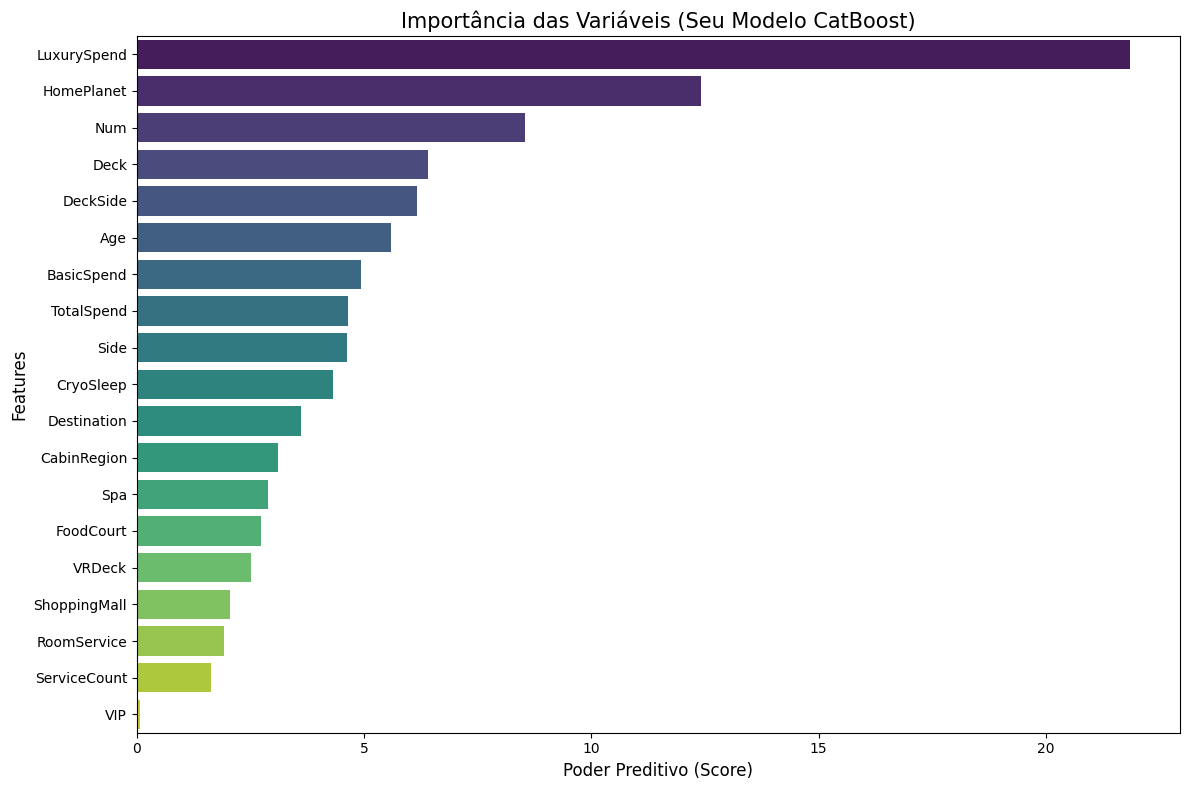


--- Top 10 Features Mais Importantes ---
        Feature  Importance
15  LuxurySpend   21.855026
0    HomePlanet   12.411039
14          Num    8.537122
4          Deck    6.399820
6      DeckSide    6.171602
7           Age    5.590014
16   BasicSpend    4.929257
13   TotalSpend    4.634335
5          Side    4.629377
1     CryoSleep    4.314996


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Extrair os valores de importância do modelo treinado
importances = model_cat.get_feature_importance(type='FeatureImportance')

# Pegar os nomes das colunas
feature_names = X_train.columns

# Criar um DataFrame para organizar e ordenar
df_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Gerar o Gráfico
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=df_importance, palette='viridis')

plt.title('Importância das Variáveis (Seu Modelo CatBoost)', fontsize=15)
plt.xlabel('Poder Preditivo (Score)', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout() # Ajusta para não cortar nomes longos
plt.show()

# Imprimir o Top 10 em texto
print("\n--- Top 10 Features Mais Importantes ---")
print(df_importance.head(10))

In [22]:
a = pd.read_csv('submission_ensemble_3models.csv')
a["Transported"].value_counts()/a["Transported"].shape[0]


Transported
True     0.520458
False    0.479542
Name: count, dtype: float64

In [ ]:
import optuna
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np


def objective(trial):
    # O Optuna vai testar valores dentro desses intervalos
    params = {
        'iterations': 1500,
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'random_strength': trial.suggest_float('random_strength', 0.0, 2.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'od_type': 'Iter',
        'od_wait': 50,
        'verbose': 0,
        'random_seed': 42,
        'cat_features': cat_features_indices 
    }
    
    # Validação Cruzada Manual (5 Folds) para garantir que o resultado é real
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    
    for train_idx, val_idx in skf.split(X_train, y_train):
        # Split
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]
        
        # Treinar
        model = CatBoostClassifier(**params)
        model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], early_stopping_rounds=50)
        
        # Avaliar
        preds = model.predict(X_val)
        scores.append(accuracy_score(y_val, preds))
    
    # Retorna a média da acurácia
    return np.mean(scores)

# Rodar a Otimização
print("Iniciando busca pelos melhores hiperparâmetros...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30) 


print("\n--- MELHORES PARÂMETROS ENCONTRADOS ---")
print(study.best_params)
print(f"Melhor Acurácia Média: {study.best_value:.4f}")

# Treinar o Modelo Final com os Melhores Parâmetros
best_params = study.best_params
best_params['iterations'] = 2000 
best_params['cat_features'] = cat_features_indices
best_params['verbose'] = 100

print("\nTreinando modelo final com os parâmetros vencedores...")
final_model = CatBoostClassifier(**best_params)
final_model.fit(X_train, y_train)

# Gerar Submissão
y_pred_bool = final_model.predict(X_test_cat).astype(bool)

submission = pd.DataFrame({
    'PassengerId': passenger_ids,
    'Transported': y_pred_bool
})
submission.to_csv('submission_catboost_optuna.csv', index=False)
print("Arquivo 'submission_catboost_optuna.csv' gerado!")

[I 2025-12-03 10:18:24,182] A new study created in memory with name: no-name-a23c7537-472a-4583-b617-c5ad479da833


Iniciando busca pelos melhores hiperparâmetros...


[I 2025-12-03 10:22:17,264] Trial 0 finished with value: 0.8035194095253345 and parameters: {'learning_rate': 0.0056709865119198765, 'depth': 4, 'l2_leaf_reg': 7.676622020052846, 'random_strength': 1.8495326087227804, 'bagging_temperature': 0.608554812314006}. Best is trial 0 with value: 0.8035194095253345.
[I 2025-12-03 10:24:02,778] Trial 1 finished with value: 0.8101917626560772 and parameters: {'learning_rate': 0.07015686468020213, 'depth': 10, 'l2_leaf_reg': 1.6744491539165938, 'random_strength': 1.1163707938609628, 'bagging_temperature': 0.9772602826757694}. Best is trial 1 with value: 0.8101917626560772.
[I 2025-12-03 10:25:12,322] Trial 2 finished with value: 0.8137576256078815 and parameters: {'learning_rate': 0.09774855848991969, 'depth': 8, 'l2_leaf_reg': 5.2405499980722, 'random_strength': 0.23940042056656985, 'bagging_temperature': 0.9241134248886071}. Best is trial 2 with value: 0.8137576256078815.
[I 2025-12-03 10:28:00,856] Trial 3 finished with value: 0.816058658369458


--- MELHORES PARÂMETROS ENCONTRADOS ---
{'learning_rate': 0.05049950733169824, 'depth': 6, 'l2_leaf_reg': 2.946925429811197, 'random_strength': 0.984401749209338, 'bagging_temperature': 0.10509030976467737}
Melhor Acurácia Média: 0.8184

Treinando modelo final com os parâmetros vencedores...
0:	learn: 0.6660386	total: 62.7ms	remaining: 2m 5s
100:	learn: 0.3746273	total: 6.77s	remaining: 2m 7s
200:	learn: 0.3513406	total: 13.8s	remaining: 2m 3s
300:	learn: 0.3286554	total: 21s	remaining: 1m 58s
400:	learn: 0.3116380	total: 28.3s	remaining: 1m 52s
500:	learn: 0.2964168	total: 35.4s	remaining: 1m 45s
600:	learn: 0.2832166	total: 42.2s	remaining: 1m 38s
700:	learn: 0.2712169	total: 49.7s	remaining: 1m 32s
800:	learn: 0.2607484	total: 56.9s	remaining: 1m 25s
900:	learn: 0.2512889	total: 1m 4s	remaining: 1m 18s
1000:	learn: 0.2431933	total: 1m 11s	remaining: 1m 11s
1100:	learn: 0.2345251	total: 1m 18s	remaining: 1m 4s
1200:	learn: 0.2272458	total: 1m 26s	remaining: 57.5s
1300:	learn: 0.2204